# News Articles Analysis


In [1]:
try:
    import re2 as re
except ImportError:
    import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [2]:
df = pd.read_csv('articles.csv')

In [3]:
df.sample(5)

,Organisation,Article
50,NaN,NaN
29,NaN,NaN
31,NaN,NaN
48,NaN,NaN
9,rte,The Government has moved to reassure victims o...


In [4]:
df.shape

(56, 2)

In [5]:
df.isnull().sum()

Organisation    30
Article         30
dtype: int64

In [4]:
df.dropna(subset = ['Article'],inplace=True)

In [5]:
df.isnull().sum()

Organisation    0
Article         0
dtype: int64

## Data Preprocessing

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','were', 'use','good','really','quite','nice','well','little','need','keep','make','abuse','take','get','very','pandemic','covid-19','lockdown','woman','grovernment','were'])

In [7]:
def reduce_lengthening(text):
    """
    Function uses regular expression to correct spelling errors from the text which involve incorrect repeated letters

    parameters:
    text (str): the text to use
    """  
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [8]:
def decontracted(phrase):
    """
    Function uses regular expression to substitute common constructs used in text which 
    involve contractions.
    A contraction is a shortened form of one or two words (one of which is usually a verb).
    e.g. 'won't' will be replaced with 'will not'

    parameters:
    text (str): the text to use
    """ 
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'didnt", " did not", phrase)
    return phrase

In [9]:
def new_line(text):
    text = re.sub(r'\t', ' ', text) # remove tabs
    text = re.sub(r'\n', ' ', text) # remove line jump
    text = re.sub(r"\s+", " ", text) # remove extra spaces
    return text

In [10]:
df.Article = df.Article.apply(reduce_lengthening,0)
df.Article = df.Article.apply(decontracted,0)
df.Article = df.Article.apply(new_line,0)

In [11]:
# Convert to list
data = df.Article.values.tolist()
pprint(data[:1])

['Up to 9.5 million women and girls could miss out on vital family planning '
 'services this year because of Covid-19, potentially resulting in thousands '
 'of deaths. Marie Stopes International warned on Friday that travel '
 'restrictions and lockdowns could have a devastating affect on women as they '
 'struggle to collect contraceptives and access other reproductive healthcare '
 'services, such as safe abortions, across the 37 countries in which it works. '
 'MSI estimates that with an 80% reduction in service delivery for three '
 'months, and minimal services for the remainder of the year, 9.5 million '
 'people will miss out. If things were to return to normal after three months '
 'of disruption, the figure would drop to 4 million. The organisation predicts '
 'that the loss of services could result in as many as 3 million additional '
 'unintended pregnancies, 2.7 million unsafe abortions and 11,00 '
 'pregnancy-related deaths. Last year, 32 million women used contraceptive

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['up', 'to', 'million', 'women', 'and', 'girls', 'could', 'miss', 'out', 'on', 'vital', 'family', 'planning', 'services', 'this', 'year', 'because', 'of', 'covid', 'potentially', 'resulting', 'in', 'thousands', 'of', 'deaths', 'marie', 'stopes', 'international', 'warned', 'on', 'friday', 'that', 'travel', 'restrictions', 'and', 'lockdowns', 'could', 'have', 'devastating', 'affect', 'on', 'women', 'as', 'they', 'struggle', 'to', 'collect', 'contraceptives', 'and', 'access', 'other', 'reproductive', 'healthcare', 'services', 'such', 'as', 'safe', 'abortions', 'across', 'the', 'countries', 'in', 'which', 'it', 'works', 'msi', 'estimates', 'that', 'with', 'an', 'reduction', 'in', 'service', 'delivery', 'for', 'three', 'months', 'and', 'minimal', 'services', 'for', 'the', 'remainder', 'of', 'the', 'year', 'million', 'people', 'will', 'miss', 'out', 'if', 'things', 'were', 'to', 'return', 'to', 'normal', 'after', 'three', 'months', 'of', 'disruption', 'the', 'figure', 'would', 'drop', 'to',

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=6) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=6)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['up', 'to', 'million_women', 'and_girls', 'could', 'miss', 'out', 'on', 'vital', 'family_planning', 'services', 'this_year', 'because_of', 'covid', 'potentially', 'resulting', 'in', 'thousands', 'of', 'deaths', 'marie_stopes', 'international', 'warned', 'on', 'friday', 'that', 'travel', 'restrictions', 'and', 'lockdowns', 'could', 'have', 'devastating', 'affect', 'on_women', 'as', 'they', 'struggle_to', 'collect', 'contraceptives', 'and', 'access', 'other', 'reproductive_healthcare', 'services', 'such_as', 'safe', 'abortions', 'across_the', 'countries', 'in', 'which', 'it', 'works', 'msi', 'estimates_that', 'with', 'an', 'reduction', 'in', 'service_delivery', 'for', 'three_months', 'and', 'minimal', 'services', 'for', 'the', 'remainder', 'of', 'the', 'year_million', 'people', 'will', 'miss', 'out', 'if', 'things', 'were', 'to', 'return', 'to', 'normal', 'after', 'three_months', 'of', 'disruption', 'the', 'figure', 'would', 'drop', 'to', 'million', 'the', 'organisation', 'predicts', 't

In [14]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

[['girl', 'service', 'year', 'thousand', 'death', 'travel', 'restriction', 'lockdown', 'woman', 'collect', 'contraceptive', 'access', 'service', 'abortion', 'country', 'reduction', 'service', 'people', 'thing', 'disruption', 'figure', 'organisation', 'loss', 'service', 'unintended_pregnancie', 'abortion', 'pregnancy', 'death', 'million_woman', 'contraceptive', 'government', 'world', 'list', 'business', 'woman', 'girl', 'pay', 'price', 'government', 'abortion', 'contraception', 'closure', 'clinic', 'country', 'government', 'travel', 'clinic', 'number', 'woman', 'abortion', 'service', 'ebola_outbreak', 'evidence', 'importance', 'service', 'researcher', 'closure', 'clinic', 'service', 'stillbirth', 'death', 'death', 'virus', 'epidemic', 'people', 'service', 'epidemic', 'number', 'woman', 'word', 'crisis', 'number', 'pregnancy', 'people', 'hospital', 'government', 'facility', 'contraception', 'post', 'abortion', 'care', 'briefing', 'paper', 'availability', 'distribution', 'health', 'medici

In [ ]:
# id2word = corpora.Dictionary(data_lemmatized)
# print('Number of unique words in initial documents:', len(id2word))
# id2word.filter_extremes(no_below=10, no_above=0.2)
# print('Number of unique words after removing rare and common words:', len(id2word))


# Topic Modelling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# print('Number of unique words in initital documents:', len(dictionary))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 5), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 3), (7, 2), (8, 1), (9, 1), (10, 2), (11, 2), (12, 2), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 4), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 3), (35, 1), (36, 1), (37, 1), (38, 3), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 8), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 4), (53, 1), (54, 1), (55, 1)]]


In [17]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abortion', 5),
  ('access', 2),
  ('availability', 1),
  ('briefing', 1),
  ('business', 1),
  ('care', 1),
  ('clinic', 3),
  ('closure', 2),
  ('collect', 1),
  ('consequence', 1),
  ('contraception', 2),
  ('contraceptive', 2),
  ('country', 2),
  ('crisis', 1),
  ('death', 4),
  ('disruption', 1),
  ('distribution', 1),
  ('ebola_outbreak', 1),
  ('epidemic', 2),
  ('evidence', 1),
  ('facility', 1),
  ('figure', 1),
  ('gain', 1),
  ('girl', 2),
  ('government', 4),
  ('health', 1),
  ('hospital', 1),
  ('importance', 1),
  ('life', 1),
  ('list', 1),
  ('lockdown', 1),
  ('loss', 1),
  ('medicine', 1),
  ('million_woman', 1),
  ('number', 3),
  ('organisation', 1),
  ('paper', 1),
  ('pay', 1),
  ('people', 3),
  ('post', 1),
  ('pregnancy', 2),
  ('price', 1),
  ('reduction', 1),
  ('researcher', 1),
  ('restriction', 1),
  ('service', 8),
  ('stillbirth', 1),
  ('thing', 1),
  ('thousand', 1),
  ('travel', 2),
  ('unintended_pregnancie', 1),
  ('virus', 1),
  ('woman', 4),


In [18]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.067*"woman" + 0.019*"home" + 0.014*"violence" + 0.013*"government" + '
  '0.011*"gender" + 0.010*"virus" + 0.010*"people" + 0.010*"help" + '
  '0.010*"victim" + 0.009*"family"'),
 (1,
  '0.034*"woman" + 0.022*"people" + 0.022*"man" + 0.019*"day" + '
  '0.019*"charity" + 0.015*"time" + 0.015*"partner" + 0.015*"week" + '
  '0.015*"crime" + 0.011*"number"'),
 (2,
  '0.027*"victim" + 0.024*"police" + 0.022*"shelter" + 0.020*"city" + '
  '0.016*"child" + 0.015*"domestic_violence" + 0.014*"day" + 0.012*"people" + '
  '0.012*"family" + 0.012*"call"'),
 (3,
  '0.036*"victim" + 0.031*"child" + 0.026*"service" + 0.019*"people" + '
  '0.014*"resource" + 0.012*"home" + 0.011*"risk" + 0.011*"violence" + '
  '0.010*"survivor" + 0.010*"family"'),
 (4,
  '0.096*"woman" + 0.040*"violence" + 0.015*"call" + 0.014*"movement" + '
  '0.014*"region" + 0.014*"femicide" + 0.014*"country" + 0.014*"case" + '
  '0.014*"government" + 0.014*"victim"'),
 (5,
  '0.062*"woman" + 0.014*"service" + 0.014*"care

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.447905212349556

Coherence Score:  0.3663420973791103


In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Katlego\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.055042 -0.109363       1        1  24.074297
0     -0.038259  0.044460       2        1  23.259670
2      0.156637 -0.008174       3        1  15.304173
7      0.064818 -0.001690       4        1  10.236959
6     -0.108183 -0.039199       5        1  10.207059
4      0.004778  0.151080       6        1   7.066537
5     -0.125517 -0.032721       7        1   6.932788
1     -0.009316 -0.004393       8        1   2.918526, topic_info=    Category        Freq        Term       Total  loglift  logprob
52   Default  171.000000       woman  171.000000  30.0000  30.0000
115  Default   56.000000    violence   56.000000  29.0000  29.0000
88   Default   22.000000         man   22.000000  28.0000  28.0000
95   Default   32.000000      police   32.000000  27.0000  27.0000
38   Default   54.000000      people   54.000000  26.0000  26.0000
..       ...         ...         ...         ...      ...      ...
24    Topic8    0.555951  government   37.649517  -0.6813  -5.4655
61    Topic8    0.549389       child   59.678242  -1.1538  -5.4774
81    Topic8    0.548100        home   46.928467  -0.9158  -5.4797
13    Topic8    0.547469      crisis   15.106903   0.2165  -5.4809
89    Topic8    0.545284     measure   16.759315   0.1087  -5.4849

[522 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.311603  abortion
0         5  0.623207  abortion
239       1  0.446227    abuser
239       2  0.223113    abuser
239       3  0.089245    abuser
...     ...       ...       ...
55        3  0.238771      year
55        4  0.079590      year
55        5  0.278567      year
55        6  0.119386      year
55        8  0.039795      year

[873 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 8, 7, 5, 6, 2])

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

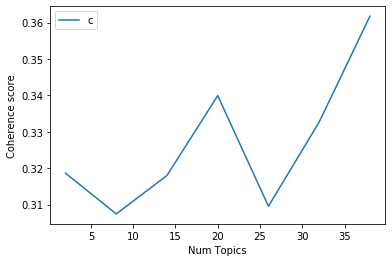

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3186
Num Topics = 8  has Coherence Value of 0.3074
Num Topics = 14  has Coherence Value of 0.318
Num Topics = 20  has Coherence Value of 0.3399
Num Topics = 26  has Coherence Value of 0.3095
Num Topics = 32  has Coherence Value of 0.3327
Num Topics = 38  has Coherence Value of 0.3618


In [29]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics())

[(0,
  '0.014*"epidemic" + 0.013*"child" + 0.013*"police" + 0.013*"woman" + '
  '0.010*"case" + 0.009*"survivor" + 0.008*"help" + 0.008*"year" + '
  '0.007*"number" + 0.007*"domestic_violence"'),
 (1,
  '0.073*"woman" + 0.016*"people" + 0.016*"government" + 0.015*"service" + '
  '0.012*"violence" + 0.012*"time" + 0.011*"victim" + 0.009*"response" + '
  '0.009*"world" + 0.009*"home"'),
 (2,
  '0.039*"victim" + 0.033*"child" + 0.021*"service" + 0.015*"people" + '
  '0.015*"home" + 0.014*"family" + 0.013*"woman" + 0.009*"emergency" + '
  '0.009*"campaign" + 0.009*"violence"'),
 (3,
  '0.044*"woman" + 0.022*"home" + 0.018*"violence" + 0.013*"people" + '
  '0.012*"help" + 0.009*"house" + 0.009*"situation" + 0.008*"household" + '
  '0.008*"gender" + 0.008*"abuser"'),
 (4,
  '0.050*"woman" + 0.018*"violence" + 0.014*"girl" + 0.013*"service" + '
  '0.013*"child" + 0.012*"victim" + 0.010*"people" + 0.010*"access" + '
  '0.010*"gender" + 0.010*"case"'),
 (5,
  '0.042*"woman" + 0.022*"violence" +

##  dominant topic in each sentence/review/document

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show

pd.set_option('display.max_colwidth', -1)
df_dominant_topic.head(10)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  0            1.0             0.9897               
1  1            6.0             0.8392               
2  2            17.0            0.9932               
3  3            1.0             0.8729               
4  4            17.0            0.9939               
5  5            12.0            0.7178               
6  6            12.0            0.9957               
7  7            9.0             0.9648               
8  8            17.0            0.9938               
9  9            2.0             0.9931               

                                                                                 Keywords  \
0  woman, people, government, service, violence, time, victim, response, world, home        
1  woman, child, victim, home, day, call, service, shelter, people, family                  
2  woman, violence, victim, government, home, country, man, partner, call, family           
3  woman, people, government, service, violence, time, victim, response, world, home        
4  woman, violence, victim, government, home, country, man, partner, call, family           
5  police, victim, child, city, people, epidemic, shelter, domestic_violence, time, woman   
6  police, victim, child, city, people, epidemic, shelter, domestic_violence, time, woman   
7  woman, victim, week, police, government, service, people, violence, call, home           
8  woman, violence, victim, government, home, country, man, partner, call, family           
9  victim, child, service, people, home, family, woman, emergency, campaign, violence       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Most representative document for each topic 

In [31]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', -1)
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0  1.0        0.9970               
1  2.0        0.9948               
2  3.0        0.5792               
3  4.0        0.5389               
4  6.0        0.9932               

                                                                             Keywords  \
0  woman, people, government, service, violence, time, victim, response, world, home    
1  victim, child, service, people, home, family, woman, emergency, campaign, violence   
2  woman, home, violence, people, help, house, situation, household, gender, abuser     
3  woman, violence, girl, service, child, victim, people, access, gender, case          
4  woman, child, victim, home, day, call, service, shelter, people, family              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

## Topic distributions across documents

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"woman, people, government, service, violence, time, victim, response, world, home",NaN,NaN
1.0,6.0,"woman, child, victim, home, day, call, service, shelter, people, family",7.0,0.2692
2.0,17.0,"woman, violence, victim, government, home, country, man, partner, call, family",3.0,0.1154
3.0,1.0,"woman, people, government, service, violence, time, victim, response, world, home",1.0,0.0385
4.0,17.0,"woman, violence, victim, government, home, country, man, partner, call, family",1.0,0.0385
5.0,12.0,"police, victim, child, city, people, epidemic, shelter, domestic_violence, time, woman",NaN,NaN
6.0,12.0,"police, victim, child, city, people, epidemic, shelter, domestic_violence, time, woman",3.0,0.1154
7.0,9.0,"woman, victim, week, police, government, service, people, violence, call, home",NaN,NaN
8.0,17.0,"woman, violence, victim, government, home, country, man, partner, call, family",2.0,0.0769
9.0,2.0,"victim, child, service, people, home, family, woman, emergency, campaign, violence",2.0,0.0769


# Sentiment Analysis

In [33]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus=corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics